# Creating the machine learning model 

## Business problem 

![CSGO-logo](media/csgo-logo.jpeg)

Imagine that we are working in a huge analytics company and our new task is to model the probability of Counter Terrorist (**CT** for short) team winning a Counter Strike: Global Offensive (**CSGO** for short) game.

The rules of the game are simple: there are two teams, named terrorists and counter-terrorists, each consisting of 5 players. At the start of the round each player buys weapons, armor and other equipment and the objective is to eliminate every single member of the opposite team. 

To read more about the game visit the official website: https://blog.counter-strike.net/index.php/about/

This esport is very popular and our analytics company is trying to break into the gaming market with a very accurate model which will be shown on TV, on gaming streams and other places. 

## Rules of the game 

The ultimate victory of a CSGO match is when a team, either CT or T, earn **16 points**. A point is earn when a match is won. 

The maximum number of seconds in a match is **175.00**.

There are 5 CT and 5 T players on match start. Each of them have **100 hit points (HP)** and can buy up to **100 armor**.

Players earn in game dollars during a match which can be spent on weapons, grenades, armor and other accesories. 

If the terrorists plant a bomb and counter-terrorists fail to defuse it, then the game lost for CTs. 

## Machine learning problem 

After the business problem is defined and the rules of the game is clear, we now need to convert the business problem into a machine learning problem. 

If we define: 

$$ \mathbb{Y}_{i} = \{0, 1\}, \forall i = 1, ..., n$$ 

$$ \mathbb{X}_{i} \in R^{p}, \forall i = 1, ..., n$$

Where

$i$ - observation i. 

$n$ - total number of observations.

$p$ - number of features.

Then we are trying to create a model for the probability:

$$P(\mathbb{Y}|\mathbb{X}) \in (0, 1)$$

The function $f$ that links $\mathbb{X}$ to $\mathbb{Y}$ is the machine learning model which are trying to build:

$$ f: \mathbb{X} \rightarrow \mathbb{Y} $$

Because we are trying to predict an observation falling into one of two categories the machine learning model $f$ can be called a *classifier*. 

We roll up our sleeves and start working on each of the steps: EDA, data spliting, model creation and validation. 

# Python package imports 

The first thing that any developer or a ML practioner does is load up packages which are installed into his/hers machine. 

In [1]:
# Data reading 
import pandas as pd 

# Main modeling class
import xgboost as xgb 

# Data spliting 
from sklearn.model_selection import train_test_split

# Plotting library
import matplotlib.pyplot as plt

# Array math 
import numpy as np

# Reading data 

Finding, cleaning and labelling data is ussually a long and painfull process. This is not the main emphasis of this book so lets imagine that we have already spent months in creating the beautifull dataset which we will read.

The original dataset can be found here: https://www.kaggle.com/christianlillelund/csgo-round-winner-classification

In [2]:
# Using pandas to read a csv file 
d = pd.read_csv("data/data.csv")

# Printing the shape of data 
print(f"Number of observations: {d.shape[0]}")
print(f"Number of features: {d.shape[1]}")

Number of observations: 122410
Number of features: 97


In [3]:
# Getting the feature names 
d.columns.values

array(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted',
       'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money',
       't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits',
       'ct_players_alive', 't_players_alive', 'ct_weapon_ak47',
       't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug', 'ct_weapon_awp',
       't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s',
       't_weapon_m4a1s', 'ct_weapon_m4a4', 't_weapon_m4a4',
       'ct_weapon_mac10', 't_weapon_mac10', 'ct_weapon_mag7',
       't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_

In [4]:
# Displaying a snippet of data
print(d.head())

   time_left  ct_score  t_score       map  bomb_planted  ct_health  t_health  \
0     175.00       0.0      0.0  de_dust2         False      500.0     500.0   
1     156.03       0.0      0.0  de_dust2         False      500.0     500.0   
2      96.03       0.0      0.0  de_dust2         False      391.0     400.0   
3      76.03       0.0      0.0  de_dust2         False      391.0     400.0   
4     174.97       1.0      0.0  de_dust2         False      500.0     500.0   

   ct_armor  t_armor  ct_money  ...  t_grenade_flashbang  \
0       0.0      0.0    4000.0  ...                  0.0   
1     400.0    300.0     600.0  ...                  0.0   
2     294.0    200.0     750.0  ...                  0.0   
3     294.0    200.0     750.0  ...                  0.0   
4     192.0      0.0   18350.0  ...                  0.0   

   ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                      0.0                     0.0   
1                      0.0                     2.0

A short description about the data from the kaggle source: 
    
*The dataset consists of round snapshots from about 700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot has been recorded every 20 seconds until the round is decided. Following its initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411. **Snapshots are i.i.d and should be treated as individual data points**, not as part of a match.*

The feature that will be used for the creation of $\mathbb{Y}$ variable is **round_winner**. If CT have won, then the value of $\mathbb{Y}$ will be 1 and 0 othervise.

In [5]:
# Creating the Y variable 
d['Y'] = [1 if x == 'CT' else 0 for x in d['round_winner']]

# Feature engineering 

Now lets create features which will be used in modeling. 

In [26]:
# Boolean for the planting of the bomb event 
d['bomb_planted'] = [1 if x else 0 for x in d['bomb_planted']]

# The differences between the team scores 
d['team_score_diff'] = d['ct_score'] - d['t_score']

# Putting the team_score_diff into buckets 
cut_bins = [-15, -5, 0, 5, 15]
d['team_score_diff'] = pd.cut(d['team_score_diff'], bins=cut_bins)

# Explanatory Data Analysis 

## Bomb planting event 

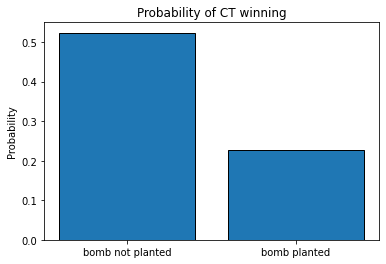

In [7]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['bomb_planted'])['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Adding a custom index 
prob_w.index = ['bomb not planted', 'bomb planted']

# Ploting the results 
plt.bar(
    prob_w.index, 
    prob_w['prob_of_win_CT'],
    edgecolor='black'
)
plt.title("Probability of CT winning")
plt.ylabel("Probability")
plt.show()

In [8]:
print(prob_w)

                    sum    size  prob_of_win_CT
bomb not planted  56904  108726        0.523371
bomb planted       3100   13684        0.226542


As we can see, if a bomb is planted, the odds of winning for a CT squad is more than two times lower than if the bomb is not planted: **0.52** and **0.22** respectively. 

## Maps 

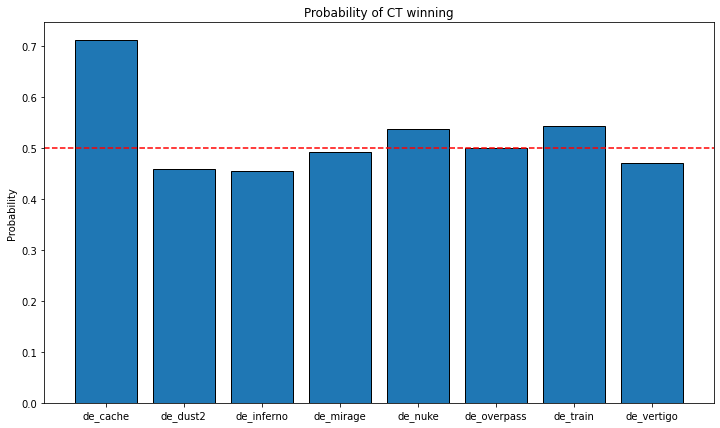

In [9]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['map'])['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Adding a custom index 
#prob_w.index = ['bomb not planted', 'bomb planted']

# Ploting the results 
plt.figure(figsize=(12, 7))
plt.bar(
    prob_w.index, 
    prob_w['prob_of_win_CT'],
    edgecolor='black'
)
plt.title("Probability of CT winning")
plt.ylabel("Probability")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

In [10]:
print(prob_w)

               sum   size  prob_of_win_CT
map                                      
de_cache       103    145        0.710345
de_dust2     10158  22144        0.458725
de_inferno   10810  23811        0.453992
de_mirage     9144  18576        0.492248
de_nuke      10214  19025        0.536873
de_overpass   7026  14081        0.498970
de_train      7310  13491        0.541843
de_vertigo    5239  11137        0.470414


The map **de_cache** seems to be a clear outlier in the dataset: the CTs are winning in this map more than 70% of the maches. 

## Tilting 

The definition of tilting in esports is ***state of mental or emotional confusion or frustration***. We can measure that by the influence of the current score of matches to the probablity of winning. 

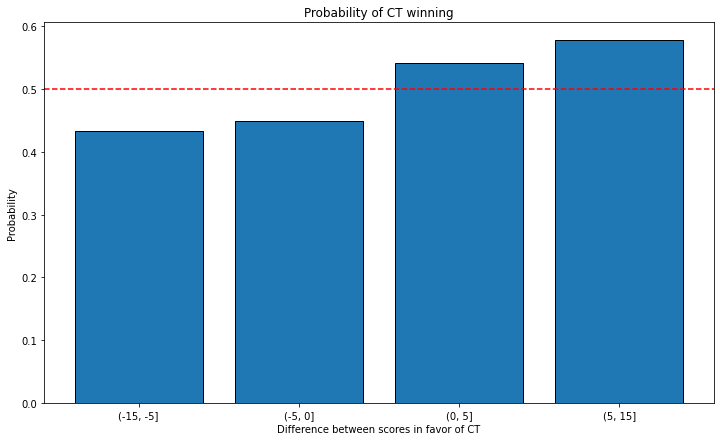

In [27]:
# Calculating the probability of winning when a bomb is planted
prob_w = d.groupby(['team_score_diff'])['Y'].agg(['sum', 'size'])
prob_w['prob_of_win_CT'] = prob_w['sum'] / prob_w['size']

# Adjusting the index
prob_w.index = [str(x) for x in prob_w.index] 

# Ploting the results 
plt.figure(figsize=(12, 7))
plt.bar(
    prob_w.index, 
    prob_w['prob_of_win_CT'],
    edgecolor='black'
)
plt.title("Probability of CT winning")
plt.ylabel("Probability")
plt.xlabel("Difference between scores in favor of CT")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

There is a relationship between the matches won by CT and the probability of winning the current match: the bigger the difference between the match score in favor of CT, the higher the chances of winning. 